## Tallo Global PFT analysis - 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

#### CSV files from the  Tallo github:

Main csv with dbh,  height, CA: https://github.com/selva-lab-repo/TALLO/tree/main/DB

Additional csv with biome info: https://github.com/selva-lab-repo/TALLO/tree/main/Jucker%20et%20al.%202022 - (Tallo_environment.csv)

In [2]:
df = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo.csv')
df_env = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_environment.csv')


#### add biome column to main data frame

In [3]:
df_tallo = pd.merge(df, df_env, on='tree_id', how='outer')

### Make a PFT column that is so far just tropical/extra tropical and broad leaf evergreen

In [4]:
print(df_tallo['biome'].unique())

['Boreal/montane forest' 'Tropical rain forest'
 'Temperate broadleaf forest' 'Tropical savanna' 'Tropical dry forest'
 'Temperate grassland' 'Temperate conifer forest' 'Mediterranean woodland'
 'Dryland' 'Mangrove']


In [5]:
def condition(x) : 
    if x == 'Boreal/montane forest':
        return 'extratrop'
    elif x == 'Tropical rain forest': 
        return 'tropical'
    elif x == 'Temperate broadleaf forest': 
        return 'extratrop'
    elif x == 'Tropical savanna': 
        return 'tropical'
    elif x == 'Tropical dry forest': 
        return 'tropical'
    elif x == 'Temperate grassland': 
        return 'extratrop'
    elif x == 'Temperate conifer forest': 
        return 'extratrop'
    elif x == 'Mediterranean woodland': 
        return 'extratrop'
    elif x == 'Dryland': 
        return 'check'
    elif x == 'Mangrove': 
        return 'check'
    
df_tallo['pft1'] = df_tallo['biome'].apply(condition)

print(df_tallo['pft1'].unique())

['extratrop' 'tropical' 'check']


In [6]:
print(df_tallo['latitude'].min())
print(df_tallo['latitude'].max())

-51.56
69.88


#### if biome isn't obvious use lat lon

In [7]:
def condition1b(x,y) : 
    if x == 'check' and abs(y) >=30 :
        return  'extratrop'
    elif x  == 'check' and abs(y) <30 :
        return 'tropical'
    else : 
        return  x
    
df_tallo['pft1'] = df_tallo.apply(lambda row: condition1b(row['pft1'],  row['latitude']), axis=1)


In [8]:
print(df_tallo['pft1'].unique())

['extratrop' 'tropical']


In [9]:
def condition2(x) : 
    if x == 'Angiosperm':
        return 'broadleaf'
    elif x == 'Gymnosperm': 
        return 'needleleaf'
   
    
df_tallo['pft2'] = df_tallo['division'].apply(condition2)

print(df_tallo['pft2'].unique())
print(df_tallo['division'].unique())

['broadleaf' 'needleleaf' None]
['Angiosperm' 'Gymnosperm' nan]


In [10]:
df_tallo['PFT_tallo'] = df_tallo['pft2'] + '_' + df_tallo['pft1']

In [11]:
print(df_tallo['PFT_tallo'].unique())

print(df_tallo.columns)

['broadleaf_extratrop' 'needleleaf_extratrop' 'broadleaf_tropical'
 'needleleaf_tropical' nan]
Index(['tree_id', 'division', 'family', 'genus', 'species', 'latitude',
       'longitude', 'stem_diameter_cm', 'height_m', 'crown_radius_m',
       'height_outlier', 'crown_radius_outlier', 'reference_id', 'realm',
       'biome', 'mean_annual_rainfall', 'rainfall_seasonality',
       'aridity_index', 'mean_annual_temperature', 'maximum_temperature',
       'pft1', 'pft2', 'PFT_tallo'],
      dtype='object')


In [12]:
# only keep relevant columns
keep = ['species', 'latitude', 'longitude', 'stem_diameter_cm', 'height_m', 'height_outlier', 'crown_radius_m', 
       'crown_radius_outlier', 'PFT_tallo']

df_tallo = df_tallo[keep]

# make a crown area column
df_tallo['crown_area']  = np.pi * df_tallo['crown_radius_m']**2 
# rename them 
new_col_names = {'stem_diameter_cm': 'dbh', 'height_m': 'height'}
df_tallo.rename(columns=new_col_names, inplace=True)

print(df_tallo.head(3))

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier             PFT_tallo  crown_area  
0            1.65                    N   broadleaf_extratrop    8.552986  
1            0.85                    N  needleleaf_extratrop    2.269801  
2            0.75                    N  needleleaf_extratrop    1.767146  


In [13]:
# Save the csv file 
df_tallo.to_csv('/pscratch/sd/j/jneedham/trait_data/Tallo_PFTs.csv', index=False)


### Plot them  - by PFT

In [14]:
lon_bl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_extratrop','longitude']
lat_bl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_extratrop','latitude']

lon_nl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'needleleaf_extratrop','longitude']
lat_nl_ex  = df_tallo.loc[df_tallo['PFT_tallo'] == 'needleleaf_extratrop','latitude']

lon_bl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','longitude']
lat_bl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','latitude']

lon_nl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','longitude']
lat_nl_tr  = df_tallo.loc[df_tallo['PFT_tallo'] == 'broadleaf_tropical','latitude']


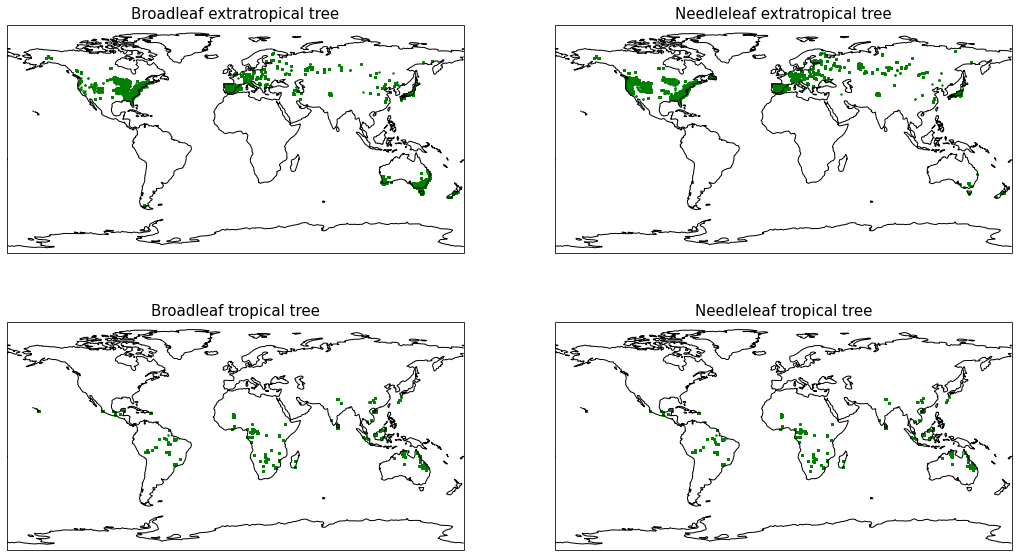

In [15]:
fig1, ((f1ax0,f1ax1),(f1ax2,f1ax3)) = plt.subplots(nrows=2,  ncols=2,
                                                   subplot_kw={'projection': ccrs.PlateCarree()},
                                                   figsize=(18,10))
# Extra tropical broadleaf
f1ax0.scatter(lon_bl_ex, lat_bl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax0.coastlines()
f1ax0.set_title('Broadleaf extratropical tree', fontsize=15)

# Extra tropical needleleaf
f1ax1.scatter(lon_nl_ex, lat_nl_ex, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax1.coastlines()
f1ax1.set_title('Needleleaf extratropical tree', fontsize=15)

# tropical broadleaf
f1ax2.scatter(lon_bl_tr, lat_bl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax2.coastlines()
f1ax2.set_title('Broadleaf tropical tree', fontsize=15)

# tropical needleleaf
f1ax3.scatter(lon_nl_tr, lat_nl_tr, color='green', s=2, marker='o', transform=ccrs.PlateCarree())
f1ax3.coastlines()
f1ax3.set_title('Needleleaf tropical tree', fontsize=15)

f1ax0.set_global()
f1ax1.set_global()
f1ax2.set_global()
f1ax3.set_global()

## Load BAAD data and make a PFT column

Analysis adapted from Adrianna Foster

In [16]:
df_baad = pd.read_csv('/pscratch/sd/j/jneedham/trait_data/baad_data_utf8.csv', encoding='utf-8')

In [17]:
def condition(x) : 
    if x == 'EA':
        return 'broadleaf_evergreen'
    elif x == 'EG': 
        return 'needleleaf_evergreen'
    elif x == 'DA': 
        return 'broadleaf_deciduous'
    elif x == 'DG': 
        return 'needleleaf_deciduous'
    
    
df_baad['pft_fates1'] = df_baad['pft'].apply(condition)

In [18]:
def condition(x) : 
    if x == 'Borf':
        return 'extratrop'
    elif x == 'TropRF': 
        return 'tropical'
    elif x == 'TempF': 
        return 'extratrop'
    elif x == 'Sh': 
        return 'check'
    elif x == 'TropSF': 
        return 'tropical'
    elif x == 'Wo': 
        return 'check'
    elif x == 'TempRF': 
        return 'extratrop'
    elif x == 'Sav': 
        return 'check'
    elif x == 'Gr': 
        return 'check'
    
df_baad['pft_fates2'] = df_baad['vegetation'].apply(condition)

In [19]:
def condition1b(x,y) : 
    if x == 'check' and abs(y) >=30 :
        return  'extratrop'
    elif x  == 'check' and abs(y) <30 :
        return 'tropical'
    else : 
        return  x
    
df_baad['pft_fates2'] = df_baad.apply(lambda row: condition1b(row['pft_fates2'],  row['latitude']), axis=1)

In [20]:
# remove green house
allowed_growth = ['FW', 'FE', 'PU', 'PM']
mask = df_baad['growingCondition'].isin(allowed_growth)
df_baad = df_baad[mask]

In [21]:
df_baad['PFT_baad'] = df_baad['pft_fates1'] + '_' + df_baad['pft_fates2']

In [22]:
# remove nans in PFT
df_baad = df_baad.dropna(subset=['PFT_baad'])
print(df_baad['PFT_baad'].unique())

['broadleaf_evergreen_tropical' 'needleleaf_evergreen_extratrop'
 'broadleaf_evergreen_extratrop' 'broadleaf_deciduous_extratrop'
 'needleleaf_deciduous_extratrop' 'broadleaf_deciduous_tropical']


In [23]:
# Select relevant columns
keep = ['PFT_baad', 'family',  'speciesMatched', 'latitude', 'longitude', 'd.bh', 'h.t', 'a.cp', 'm.so', 'r.st']
df_baad = df_baad[keep]

# rename columns 
new_col_names = {'speciesMatched': 'species', 'd.bh': 'dbh', 'h.t': 'height', 'a.cp': 'crown_area',  'm.so': 'agb', 'r.st': 'wd'}
df_baad.rename(columns=new_col_names, inplace=True)

print(df_baad.head(3))

                        PFT_baad            family       species  latitude  \
17  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   
18  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   
19  broadleaf_evergreen_tropical  Dipterocarpaceae  Shorea acuta      4.03   

    longitude  dbh  height  crown_area      agb  wd  
17     113.83  NaN    0.15      0.0449  0.00274 NaN  
18     113.83  NaN    0.39      0.0570  0.00441 NaN  
19     113.83  NaN    0.43      0.0471  0.00277 NaN  


In [24]:
# keep only plants  with dbh
df_baad = df_baad.dropna(subset=['dbh'])
# convert dbh  to cm 
df_baad['dbh'] = df_baad['dbh'] * 100.0
#print(df_baad.head(3))

print(df_baad.loc[df_baad['PFT_baad'] ==  'needleleaf_deciduous_extratrop'])

                             PFT_baad    family             species  latitude  \
3483   needleleaf_deciduous_extratrop  Pinaceae  Larix occidentalis     47.44   
3509   needleleaf_deciduous_extratrop  Pinaceae  Larix occidentalis     47.44   
3533   needleleaf_deciduous_extratrop  Pinaceae  Larix occidentalis     47.44   
3539   needleleaf_deciduous_extratrop  Pinaceae  Larix occidentalis     47.44   
3566   needleleaf_deciduous_extratrop  Pinaceae  Larix occidentalis     47.44   
...                               ...       ...                 ...       ...   
18301  needleleaf_deciduous_extratrop  Pinaceae     Larix kaempferi     42.75   
18302  needleleaf_deciduous_extratrop  Pinaceae     Larix kaempferi     42.75   
18303  needleleaf_deciduous_extratrop  Pinaceae     Larix kaempferi     42.75   
18304  needleleaf_deciduous_extratrop  Pinaceae     Larix kaempferi     42.75   
18305  needleleaf_deciduous_extratrop  Pinaceae     Larix kaempferi     42.75   

       longitude     dbh   

In [25]:
print(df_tallo.head(3))

            species  latitude  longitude   dbh  height height_outlier  \
0  Betula pubescens    67.395     28.723  10.0     5.6              N   
1       Picea abies    67.395     28.723  10.0     6.6              N   
2       Picea abies    67.395     28.723  10.0     8.5              N   

   crown_radius_m crown_radius_outlier             PFT_tallo  crown_area  
0            1.65                    N   broadleaf_extratrop    8.552986  
1            0.85                    N  needleleaf_extratrop    2.269801  
2            0.75                    N  needleleaf_extratrop    1.767146  


## Use Tallo for tropical and BAAD for  extra tropical 

### Martinez-cano height allometry

In [26]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


#### Broadleaf tropical

[79.11868992  0.8073981  47.68568981]


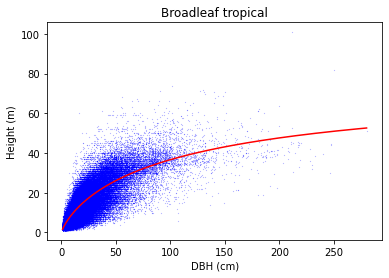

In [27]:
# Broadleaf tropical
bltr = df_tallo[df_tallo.PFT_tallo=='broadleaf_tropical']
bltr =  bltr.dropna(subset=['height', 'dbh'])
# remove outliers
bltr = bltr[bltr['height_outlier'] == 'N']

height_ps_bltr, height_cov_bltr = curve_fit(f=d2hmc, xdata=np.array(bltr['dbh']), ydata=np.array(bltr['height']),
                                           p0=initial_guess)

dbh_bltr = np.arange(1,bltr['dbh'].max(),1)

bltr_curve = [d2hmc(d, height_ps_bltr[0], height_ps_bltr[1], height_ps_bltr[2])  for  d  in dbh_bltr]

plt.scatter(bltr.dbh, bltr.height, s=0.01, color='blue')
plt.plot(dbh_bltr, bltr_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf tropical')

print(height_ps_bltr)

#### Needleleaf evergreen extra tropical  

[185.55591007   0.88762969 162.15288494]


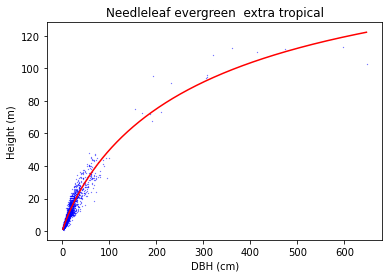

In [28]:
# Needleleaf evergreen extra tropical 
nleex = df_baad[df_baad.PFT_baad=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['height', 'dbh'])

height_ps_nleex, height_cov_nleex = curve_fit(f=d2hmc, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['height']),
                                           p0=initial_guess)

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

nleex_curve = [d2hmc(d, height_ps_nleex[0], height_ps_nleex[1], height_ps_nleex[2])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.height, s=0.05, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Needleleaf evergreen  extra tropical')

print(height_ps_nleex)

#### Needleleaf deciduous extra tropical 

[55.34315077  0.99326571 45.40571191]


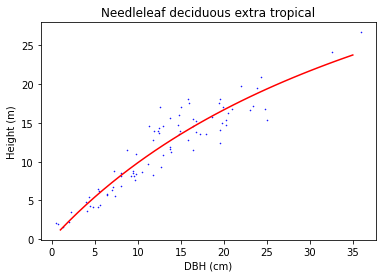

In [29]:
# Needleleaf deciduous extra tropical 
nldex = df_baad[df_baad.PFT_baad=='needleleaf_deciduous_extratrop']
nldex =  nldex.dropna(subset=['height', 'dbh'])

height_ps_nldex, height_cov_nldex = curve_fit(f=d2hmc, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['height']),
                                           p0=initial_guess)

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)

nldex_curve = [d2hmc(d, height_ps_nldex[0], height_ps_nldex[1], height_ps_nldex[2])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.height, s=0.3, color='blue')
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Needleleaf deciduous extra tropical')

print(height_ps_nldex)

#### Broadleaf evergreen extra tropical  

[4.70877493e+08 6.61191900e-01 2.28071108e+08]


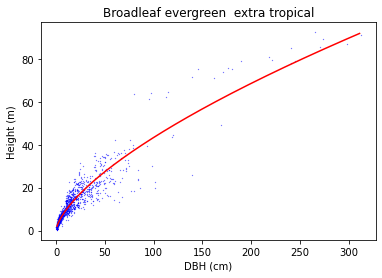

In [30]:
# Broadleaf evergreen extra tropical 
bleex = df_baad[df_baad.PFT_baad=='broadleaf_evergreen_extratrop']
bleex =  bleex.dropna(subset=['height', 'dbh'])

height_ps_bleex, height_cov_bleex = curve_fit(f=d2hmc, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['height']),
                                           p0=initial_guess)

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)

bleex_curve = [d2hmc(d, height_ps_bleex[0], height_ps_bleex[1], height_ps_bleex[2])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.height, s=0.05, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf evergreen  extra tropical')

print(height_ps_bleex)

#### Broadleaf deciduous extra tropical 

[40.53615797  0.86508191 20.34552523]


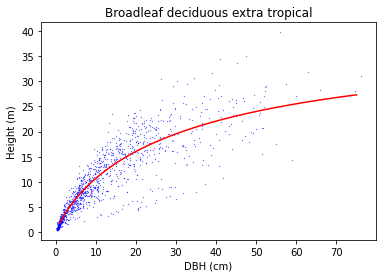

In [31]:
# Broadleaf deciduous extra tropical 
bldex = df_baad[df_baad.PFT_baad=='broadleaf_deciduous_extratrop']
bldex =  bldex.dropna(subset=['height', 'dbh'])

height_ps_bldex, height_cov_bldex = curve_fit(f=d2hmc, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['height']),
                                           p0=initial_guess)

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)

bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.height, s=0.05, color='blue')
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Broadleaf deciduous extra tropical')

print(height_ps_bldex)

#### BAAD for extra tropical and Tallo for tropical 

''

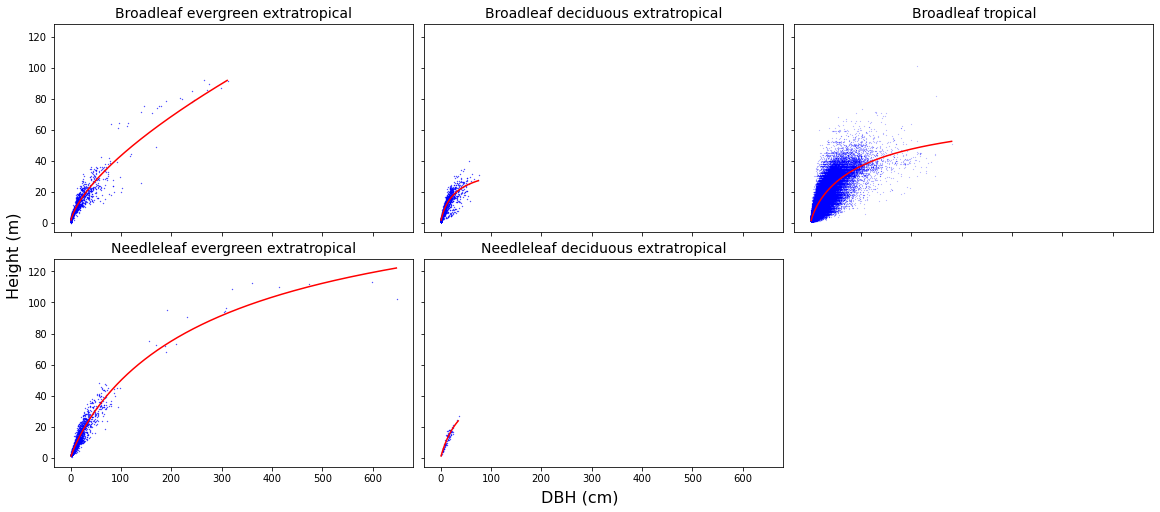

In [32]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), sharex=True, sharey=True, constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.height, s=0.1, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.height, s=0.1, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.height, s=0.1, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.height, s=0.1, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.height, s=0.01, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('Broadleaf tropical', fontsize=14)

f2ax5.axis('off')

fig2.supylabel('Height (m)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;

In [33]:
dbh = np.arange(1,350,1)
bldex_curve = [d2hmc(d, height_ps_bldex[0], height_ps_bldex[1], height_ps_bldex[2])  for  d  in dbh]
nldex_curve = [d2hmc(d, height_ps_nldex[0], height_ps_nldex[1], height_ps_nldex[2])  for  d  in dbh]
bleex_curve = [d2hmc(d, height_ps_bleex[0], height_ps_bleex[1], height_ps_bleex[2])  for  d  in dbh]
nleex_curve = [d2hmc(d, height_ps_nleex[0], height_ps_nleex[1], height_ps_nleex[2])  for  d  in dbh]
bltr_curve = [d2hmc(d, height_ps_bltr[0], height_ps_bltr[1], height_ps_bltr[2])  for  d  in dbh]


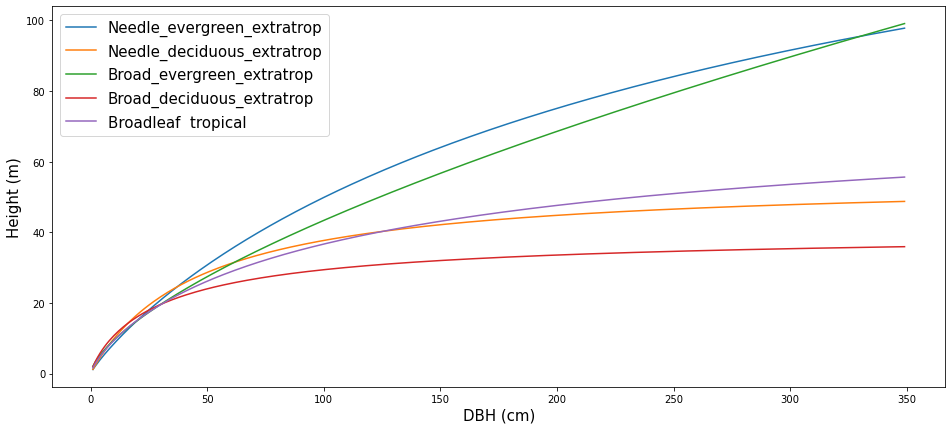

In [34]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        figsize=(16,7))

f2ax0.plot(dbh, nleex_curve, label =  'Needle_evergreen_extratrop')
f2ax0.plot(dbh, nldex_curve, label =  'Needle_deciduous_extratrop')
f2ax0.plot(dbh, bleex_curve, label =  'Broad_evergreen_extratrop')
f2ax0.plot(dbh, bldex_curve, label =  'Broad_deciduous_extratrop')
f2ax0.plot(dbh, bltr_curve, label =  'Broadleaf  tropical')
f2ax0.set_xlabel('DBH (cm)', fontsize=15)
f2ax0.set_ylabel('Height (m)',  fontsize=15)
f2ax0.legend(fontsize=15)

### Crown area allometry

In [35]:
def d2ca (d, p1) :
    ca = d ** p1
    return ca

[1.1792365]


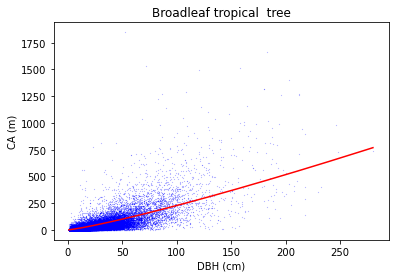

In [36]:
# Broadleaf tropical
bltr = df_tallo[df_tallo.PFT_tallo=='broadleaf_tropical']
# remove outliers
bltr = bltr[bltr['crown_radius_outlier'] == 'N']

bltr =  bltr.dropna(subset=['crown_area', 'dbh'])
ca_ps_bltr, ca_cov_bltr = curve_fit(f=d2ca, xdata=np.array(bltr['dbh']), ydata=np.array(bltr['crown_area']))

bltr_curve = [d2ca(d, ca_ps_bltr[0])  for  d  in dbh_bltr]

plt.scatter(bltr.dbh, bltr.crown_area, s=0.01, color='blue')
plt.plot(dbh_bltr, bltr_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Broadleaf tropical  tree')

print(ca_ps_bltr)

[0.8487614]


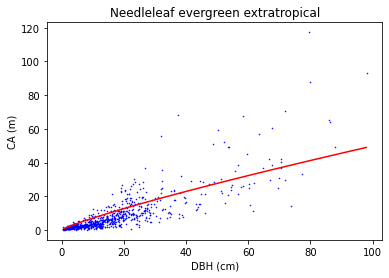

In [37]:
# Needleleaf  evergreen extra tropical
nleex = df_baad[df_baad.PFT_baad=='needleleaf_evergreen_extratrop']

nleex =  nleex.dropna(subset=['crown_area', 'dbh'])
ca_ps_nleex, ca_cov_nleex = curve_fit(f=d2ca, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['crown_area']))

dbh_nleex = np.arange(1,nleex['dbh'].max(),1)
nleex_curve = [d2ca(d, ca_ps_nleex[0])  for  d  in dbh_nleex]

plt.scatter(nleex.dbh, nleex.crown_area, s=0.3, color='blue')
plt.plot(dbh_nleex, nleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Needleleaf evergreen extratropical')

print(ca_ps_nleex)

[0.55185847]


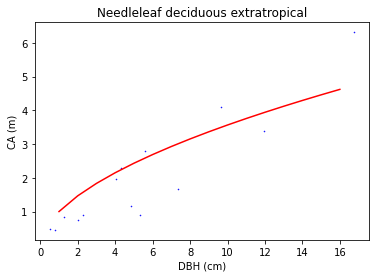

In [38]:
# Needleleaf  deciduous extra tropical
nldex = df_baad[df_baad.PFT_baad=='needleleaf_deciduous_extratrop']

nldex =  nldex.dropna(subset=['crown_area', 'dbh'])
ca_ps_nldex, ca_cov_nldex = curve_fit(f=d2ca, xdata=np.array(nldex['dbh']), ydata=np.array(nldex['crown_area']))

dbh_nldex = np.arange(1,nldex['dbh'].max(),1)
nldex_curve = [d2ca(d, ca_ps_nldex[0])  for  d  in dbh_nldex]

plt.scatter(nldex.dbh, nldex.crown_area, s=0.3, color='blue')
plt.plot(dbh_nldex, nldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Needleleaf deciduous extratropical')

print(ca_ps_nldex)

[1.1800264]


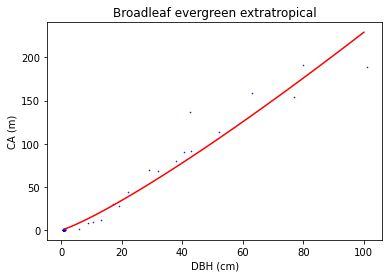

In [39]:
# broadleaf  evergreen extra tropical
bleex = df_baad[df_baad.PFT_baad=='broadleaf_evergreen_extratrop']

bleex =  bleex.dropna(subset=['crown_area', 'dbh'])
ca_ps_bleex, ca_cov_bleex = curve_fit(f=d2ca, xdata=np.array(bleex['dbh']), ydata=np.array(bleex['crown_area']))

dbh_bleex = np.arange(1,bleex['dbh'].max(),1)
bleex_curve = [d2ca(d, ca_ps_bleex[0])  for  d  in dbh_bleex]

plt.scatter(bleex.dbh, bleex.crown_area, s=0.3, color='blue')
plt.plot(dbh_bleex, bleex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Broadleaf evergreen extratropical')

print(ca_ps_bleex)

[1.22998925]


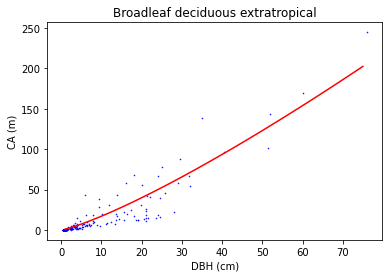

In [40]:
# broadleaf deciduous extra tropical
bldex = df_baad[df_baad.PFT_baad=='broadleaf_deciduous_extratrop']

bldex =  bldex.dropna(subset=['crown_area', 'dbh'])
ca_ps_bldex, ca_cov_bldex = curve_fit(f=d2ca, xdata=np.array(bldex['dbh']), ydata=np.array(bldex['crown_area']))

dbh_bldex = np.arange(1,bldex['dbh'].max(),1)
bldex_curve = [d2ca(d, ca_ps_bldex[0])  for  d  in dbh_bldex]

plt.scatter(bldex.dbh, bldex.crown_area, s=0.3, color='blue')
plt.plot(dbh_bldex, bldex_curve, color='red')
plt.xlabel('DBH (cm)')
plt.ylabel('CA (m)')
plt.title('Broadleaf deciduous extratropical')

print(ca_ps_bldex)

''

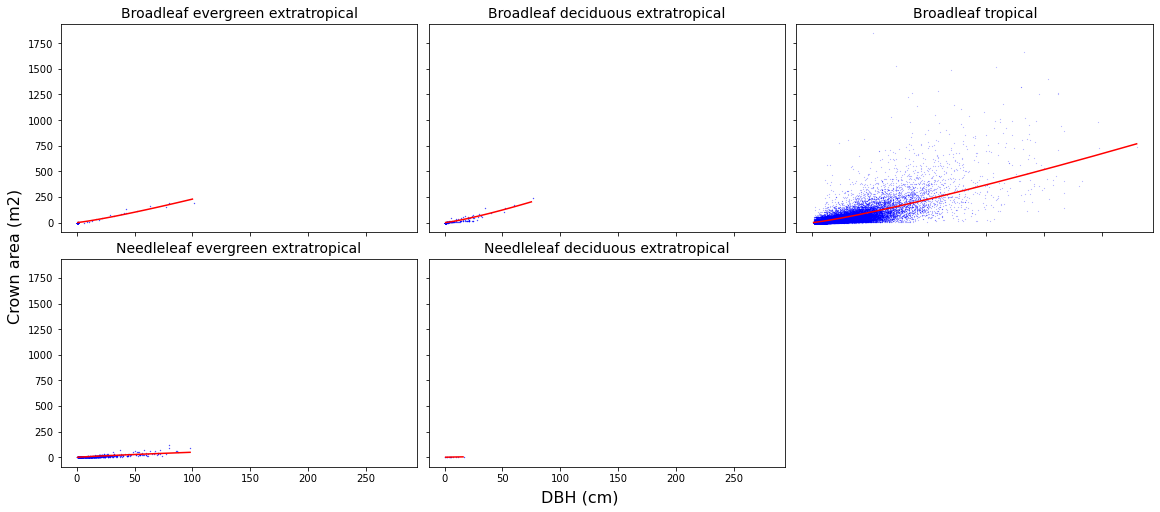

In [41]:
fig2, ((f2ax0, f2ax1, f2ax2),(f2ax3,f2ax4,f2ax5)) = plt.subplots(nrows=2,ncols=3,
                        figsize=(16,7), sharex=True, sharey=True, constrained_layout=True)

f2ax3.scatter(nleex.dbh, nleex.crown_area, s=0.1, color='blue')
f2ax3.plot(dbh_nleex, nleex_curve, color='red')
f2ax3.set_title('Needleleaf evergreen extratropical', fontsize=14)

f2ax4.scatter(nldex.dbh, nldex.crown_area, s=0.1, color='blue')
f2ax4.plot(dbh_nldex, nldex_curve, color='red')
f2ax4.set_title('Needleleaf deciduous extratropical', fontsize=14)

f2ax0.scatter(bleex.dbh, bleex.crown_area, s=0.1, color='blue')
f2ax0.plot(dbh_bleex, bleex_curve, color='red')
f2ax0.set_title('Broadleaf evergreen extratropical', fontsize=14)

f2ax1.scatter(bldex.dbh, bldex.crown_area, s=0.1, color='blue')
f2ax1.plot(dbh_bldex, bldex_curve, color='red')
f2ax1.set_title('Broadleaf deciduous extratropical', fontsize=14)

f2ax2.scatter(bltr.dbh, bltr.crown_area, s=0.01, color='blue')
f2ax2.plot(dbh_bltr, bltr_curve, color='red')
f2ax2.set_title('Broadleaf tropical', fontsize=14)

f2ax5.axis('off')

fig2.supylabel('Crown area (m2)', fontsize=16)
fig2.supxlabel('DBH (cm)', fontsize=16)
;

In [45]:
dbh = np.arange(1,350,1)
bldex_curve = [d2ca(d, ca_ps_bldex[0])  for  d  in dbh]
nldex_curve = [d2ca(d, ca_ps_nldex[0])  for  d  in dbh]
bleex_curve = [d2ca(d, ca_ps_bleex[0])  for  d  in dbh]
nleex_curve = [d2ca(d, ca_ps_nleex[0])  for  d  in dbh]
bltr_curve = [d2ca(d, ca_ps_bltr[0])  for  d  in dbh]


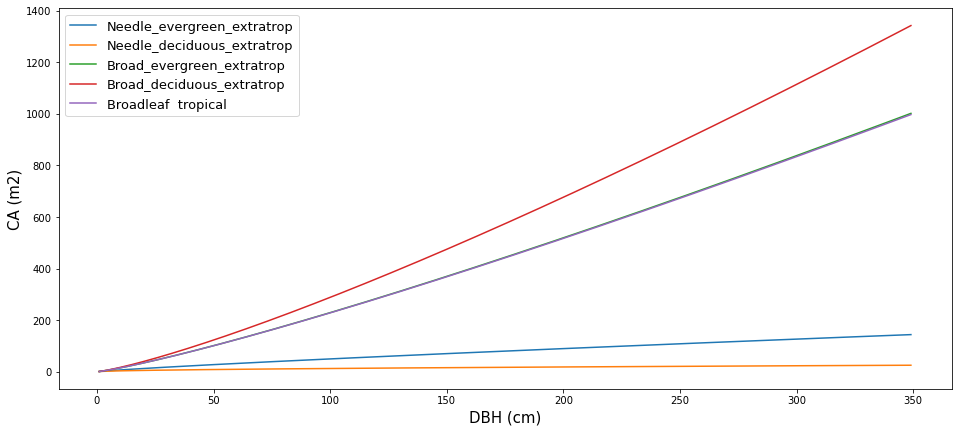

In [49]:
fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1,
                        figsize=(16,7))

f2ax0.plot(dbh, nleex_curve, label =  'Needle_evergreen_extratrop')
f2ax0.plot(dbh, nldex_curve, label =  'Needle_deciduous_extratrop')
f2ax0.plot(dbh, bleex_curve, label =  'Broad_evergreen_extratrop')
f2ax0.plot(dbh, bldex_curve, label =  'Broad_deciduous_extratrop')
f2ax0.plot(dbh, bltr_curve, label =  'Broadleaf  tropical')
f2ax0.set_xlabel('DBH (cm)', fontsize=15)
f2ax0.set_ylabel('CA (m2)',  fontsize=15)
f2ax0.legend(fontsize=13)

## Aboveground biomass

We will only do  this for extra tropical since the tropical PFTs can use Chave 2014 parameters.
We will likely need to read in wood density estimates for many species that are lacking data in BAAD.

In [51]:
def dh2bagw_chave2014 (d, h, p1,  p2,  wd) :
    bagw = (p1 * (wd * d**2 * h) **  p2)  / 2.0
    return bagw

In [52]:
# Needleleaf evergreen extra tropical 
nleex = df_baad[df_baad.PFT_baad=='needleleaf_evergreen_extratrop']
nleex =  nleex.dropna(subset=['agb', 'dbh', 'wd'])

print(len(nleex))

# agb_ps_nleex, agb_cov_nleex = curve_fit(f=dh2bagw_chave2014, xdata=np.array(nleex['dbh']), ydata=np.array(nleex['agb']),
#                                            p0=initial_guess)

# dbh_nleex = np.arange(1,nleex['dbh'].max(),1)

# nleex_curve = [d2hmc(d, height_ps_nleex[0], height_ps_nleex[1], height_ps_nleex[2])  for  d  in dbh_nleex]

# plt.scatter(nleex.dbh, nleex.height, s=0.05, color='blue')
# plt.plot(dbh_nleex, nleex_curve, color='red')
# plt.xlabel('DBH (cm)')
# plt.ylabel('Height (m)')
# plt.title('Needleleaf evergreen  extra tropical')

# print(height_ps_nleex)

0
